
### dataset = Crack 500



## Loading the important libraries and Dataset

In [1]:
! nvidia-smi

Thu Mar 31 21:30:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 N/A |                  N/A |
| 40%   33C    P0    N/A /  N/A |    348MiB /  4041MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [5]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

In [6]:
import os
import zipfile


### Loading the data and splitting it into training and validation set.

In [7]:
train_image_dir = r'/home/ubuntu/Desktop/NNDL Project/CRACK500/traincrop'
# train_mask_dir = r'/content/CRACK500/traindata/mask'

valid_image_dir = '/home/ubuntu/Desktop/NNDL Project/CRACK500/valcrop'
# valid_mask_dir = '/content/CRACK500/valdata/mask'

test_image_dir = '/home/ubuntu/Desktop/NNDL Project/CRACK500/testcrop'
# test_mask_dir = '/content/CRACK500/testdata/mask'

In [8]:
# test_image_dir = '/content/CRACK500_CROP/testcrop/image'
# test_mask_dir = '/content/CRACK500_CROP/testcrop/mask'
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))

valid_image_paths = sorted([os.path.join(valid_image_dir, fname) for fname in os.listdir(valid_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
valid_mask_paths = sorted([os.path.join(valid_image_dir, fname) for fname in os.listdir(valid_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
print("Number of validation images : ", len(valid_image_paths))
print("Number of validation masks : ", len(valid_mask_paths))

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
test_mask_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
print("Number of testing images : ", len(test_image_paths))
print("Number of testing masks : ", len(test_mask_paths))

Number of training images :  1896
Number of training masks :  1896
Number of validation images :  348
Number of validation masks :  348
Number of testing images :  1124
Number of testing masks :  1124


In [9]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [10]:
# Splitting
train_image_files = train_image_paths
train_mask_files = train_mask_paths

valid_image_files = valid_image_paths
valid_mask_files = valid_mask_paths

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


1896 1896
348 348


In [11]:
batch_size = 5
img_dim=(256, 256)

# Generator to load and augment the image batch wise

In [12]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [                   
      Flip(p=0.7),
      Rotate(p=0.7),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3),
      OneOf([
              ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
              GridDistortion(),
              OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=0.3),
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
      batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])

      if self.augment is True:
        aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255, batch_y/1  

/home/ubuntu/anaconda3/envs/nndl/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ubuntu/anaconda3/envs/nndl/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [13]:
test1_generator=Generator(test_image_paths,test_mask_paths)


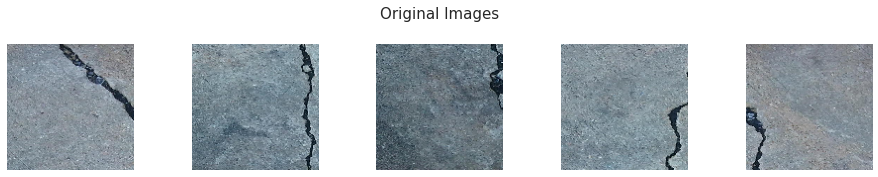

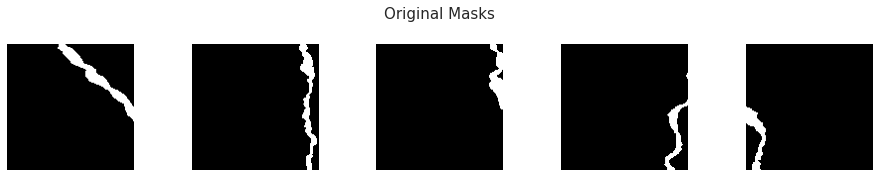

In [14]:
# Validation generator samples (Un-augmented)
for i, j in test1_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
train_generator = Generator(train_image_files, train_mask_files)
validation_generator = Generator(valid_image_files, valid_mask_files)


In [16]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [17]:
for i, j in validation_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


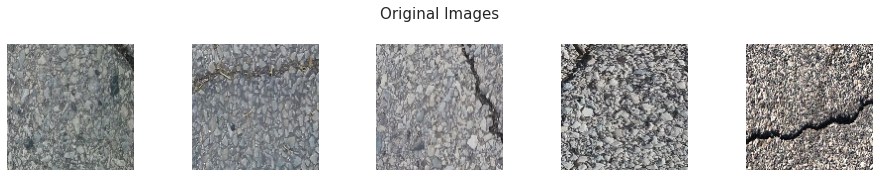

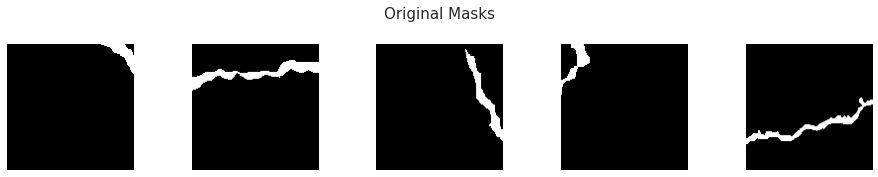

In [18]:
# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

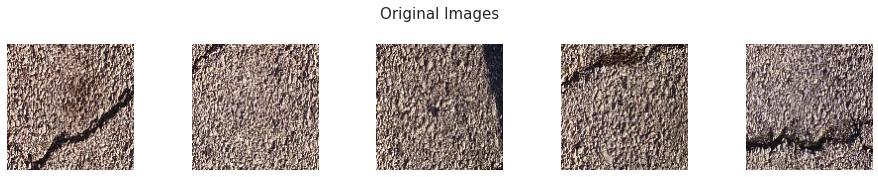

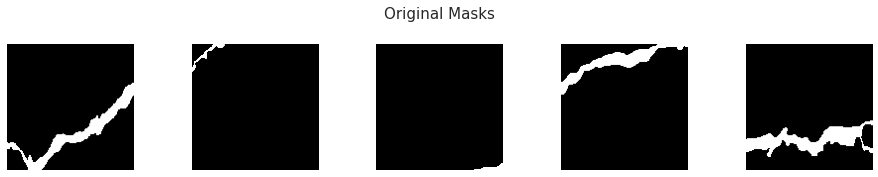

In [19]:
# Validation generator samples (Un-augmented)
for i, j in validation_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)
vg = Generator(valid_image_files, valid_mask_files, batch_size, img_dim, augment = False)

In [21]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


In [22]:
for i, j in vg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


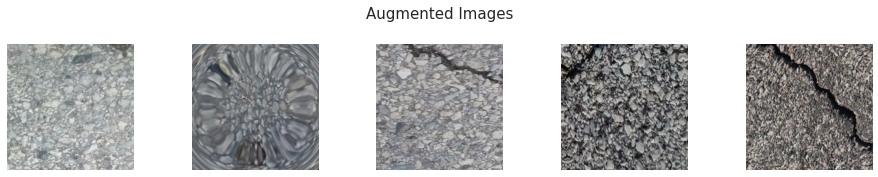

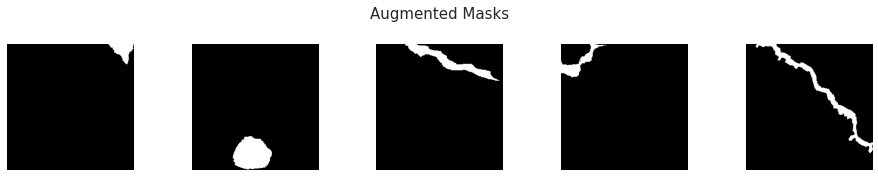

In [23]:
# Augmented train
for i, j in tg:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model

In [24]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate
from tensorflow.keras.regularizers import l2

In [25]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [26]:
#conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [27]:
#Fixed layer.
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    
    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([conv, shortcut])
    return output

In [28]:
# Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)
    
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([shortcut, res])
    return output

In [29]:
# Upsampling Concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [30]:
# MODEL
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))
    
    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)
    
    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)
    
    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [32]:
K.clear_session()
model = ResUNet()

2022-03-31 21:31:44.369177: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-31 21:31:44.374157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 21:31:44.377238: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [115]:
# from tensorflow.keras.utils import  plot_model/home/ubuntu/Desktop/NNDL Project/CRACK500/

# plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=100,
# )

# Loss
# &
# Compile

In [34]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou



In [35]:
def lr_schedule(epoch):

    lr =0.0035
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD

In [37]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [38]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.0035


# Training

In [39]:
train_steps = len(train_image_files)//batch_size
valid_steps = len(valid_image_files)//batch_size

history = model.fit(
    tg, 
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=50,
    validation_data = vg,    
    validation_steps = valid_steps,callbacks=callbacks)


2022-03-31 21:32:50.958835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-31 21:32:50.990826: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


Epoch 1/50
Learning rate:  0.0035
379/379 [==============================] - 1619s 4s/step - loss: 0.4148 - accuracy: 0.9342 - IOU: 0.4316 - dice_coef: 0.5851 - val_loss: 0.4197 - val_accuracy: 0.9203 - val_IOU: 0.4403 - val_dice_coef: 0.5803
Epoch 2/50
Learning rate:  0.0035
379/379 [==============================] - 1629s 4s/step - loss: 0.3397 - accuracy: 0.9550 - IOU: 0.5013 - dice_coef: 0.6591 - val_loss: 0.3759 - val_accuracy: 0.9603 - val_IOU: 0.4790 - val_dice_coef: 0.6241
Epoch 3/50
Learning rate:  0.0035
379/379 [==============================] - 1704s 4s/step - loss: 0.3349 - accuracy: 0.9550 - IOU: 0.5073 - dice_coef: 0.6650 - val_loss: 0.3991 - val_accuracy: 0.9587 - val_IOU: 0.4666 - val_dice_coef: 0.6009
Epoch 4/50
Learning rate:  0.0035
379/379 [==============================] - 1719s 5s/step - loss: 0.3018 - accuracy: 0.9630 - IOU: 0.5456 - dice_coef: 0.6978 - val_loss: 0.3079 - val_accuracy: 0.9630 - val_IOU: 0.5476 - val_dice_coef: 0.6921
Epoch 5/50
Learning rate:  0

379/379 [==============================] - 1646s 4s/step - loss: 0.2364 - accuracy: 0.9691 - IOU: 0.6226 - dice_coef: 0.7635 - val_loss: 0.2271 - val_accuracy: 0.9764 - val_IOU: 0.6475 - val_dice_coef: 0.7729
Epoch 35/50
Learning rate:  0.00175
379/379 [==============================] - 1649s 4s/step - loss: 0.2351 - accuracy: 0.9702 - IOU: 0.6249 - dice_coef: 0.7649 - val_loss: 0.2140 - val_accuracy: 0.9775 - val_IOU: 0.6614 - val_dice_coef: 0.7860
Epoch 36/50
Learning rate:  0.00175
379/379 [==============================] - 1656s 4s/step - loss: 0.2370 - accuracy: 0.9702 - IOU: 0.6217 - dice_coef: 0.7624 - val_loss: 0.2187 - val_accuracy: 0.9768 - val_IOU: 0.6558 - val_dice_coef: 0.7813
Epoch 37/50
Learning rate:  0.00175
379/379 [==============================] - 1653s 4s/step - loss: 0.2480 - accuracy: 0.9699 - IOU: 0.6103 - dice_coef: 0.7519 - val_loss: 0.2205 - val_accuracy: 0.9774 - val_IOU: 0.6541 - val_dice_coef: 0.7795
Epoch 38/50
Learning rate:  0.00175
379/379 [===========

In [40]:
# save model
model.save('crack500.h5')
print('Model Saved!')

Model Saved!


In [41]:
# saving and loading the model weights
 
# save model
model.save_weights('crack500_weights')
print('Model Saved!')
 
# load model
# savedModel = model.load_weights('gfgModelWeights')
# print('Model Loaded!')

Model Saved!


In [42]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

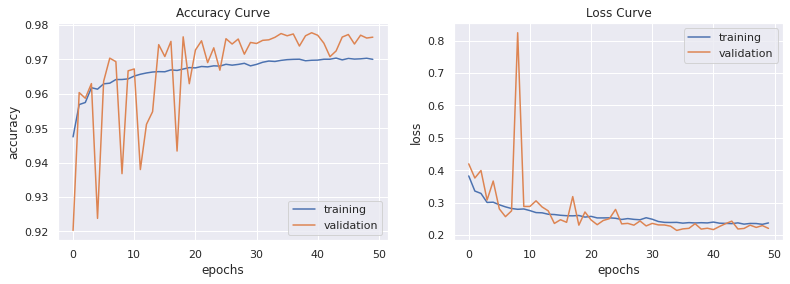

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [44]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

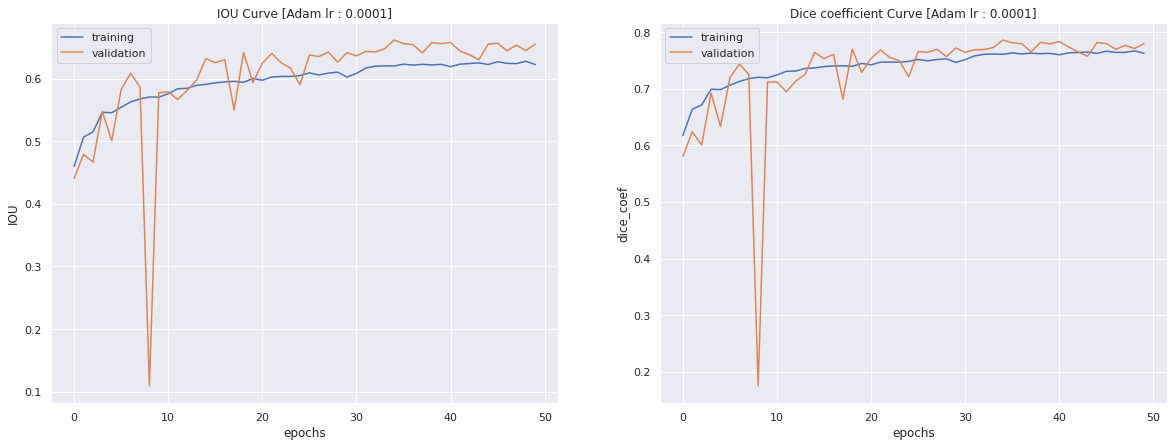

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()


axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

## Testing

In [46]:
for i, j in test1_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [47]:
ttg = Generator(test_image_paths,test_mask_paths, batch_size, img_dim, augment = False)

In [48]:
for i, j in ttg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


In [66]:
test_generator = Generator(test_image_paths,test_mask_paths,1124, img_dim)

for x_test, y_test in test_generator:
  break

print(x_test.shape)
print(y_test.shape)

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

print(yy_true.shape)
print(yy_pred.shape)

(1124, 256, 256, 3)
(1124, 256, 256, 1)
(73662464,)
(73662464,)


In [60]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9662

Precision: 0.6917

Recall: 0.7746

F1-Score: 0.7308

Sensitivity: 0.7746

Specificity: 0.9783

AUC: 0.9145

IOU: 0.5758

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.99      0.98      0.98  69301712
        True       0.69      0.77      0.73   4360752

    accuracy                           0.97  73662464
   macro avg       0.84      0.88      0.86  73662464
weighted avg       0.97      0.97      0.97  73662464



train image and label size
(360, 640, 3)
(360, 640)
validation image and label size
(360, 640, 3)
(360, 640)
test image and label size
(640, 360, 3)
(640, 360)
our test image and label size
(256, 256, 3)
(256, 256)


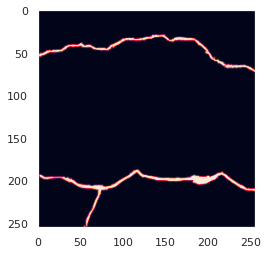

In [77]:
print('train image and label size')
img_t1 = cv2.imread('/home/ubuntu/Desktop/NNDL Project/CRACK500/traincrop/20160222_081011_1_361.jpg', -1)
img_l1 = cv2.imread('/home/ubuntu/Desktop/NNDL Project/CRACK500/traincrop/20160222_081011_1_361.png', -1)
print(img_t1.shape)
print(img_l1.shape)
print('validation image and label size')
img_t2 = cv2.imread('/home/ubuntu/Desktop/NNDL Project/CRACK500/valcrop/20160222_080850_1_361.jpg', -1)
img_l2 = cv2.imread('/home/ubuntu/Desktop/NNDL Project/CRACK500/valcrop/20160222_080850_1_361.png', -1)
print(img_t2.shape)
print(img_l2.shape)
print('test image and label size')
img_t3 = cv2.imread('/home/ubuntu/Desktop/NNDL Project/CRACK500/testcrop/20160222_080933_361_1.jpg', -1)
img_l3 = cv2.imread('/home/ubuntu/Desktop/NNDL Project/CRACK500/testcrop/20160222_080933_361_1.png', -1)
print(img_t3.shape)
print(img_l3.shape)
print('our test image and label size')
img_t4 = cv2.imread('/home/ubuntu/Desktop/NNDL Project/PIPE NEW 256/Pipe (1).jpg', -1)
img_l4 = cv2.imread('/home/ubuntu/Desktop/Pipe (1) GT.png', -1)
print(img_t4.shape)
print(img_l4[:,:,0].shape)

plt.grid(False)
plt.imshow(img_l4[:,:,0])
plt.show()

(9, 256, 256, 3)
(9, 256, 256, 3, 1)
(9, 256, 256, 3)
(9, 256, 256, 1)
(589824,)
(589824,)
(589824,)
(589824,)
Accuracy: 0.9067

Precision: 0.3449

Recall: 0.4165

F1-Score: 0.3773

Sensitivity: 0.4165

Specificity: 0.9424

AUC: 0.7195

IOU: 0.2325

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.96      0.94      0.95    549788
        True       0.34      0.42      0.38     40036

    accuracy                           0.91    589824
   macro avg       0.65      0.68      0.66    589824
weighted avg       0.92      0.91      0.91    589824



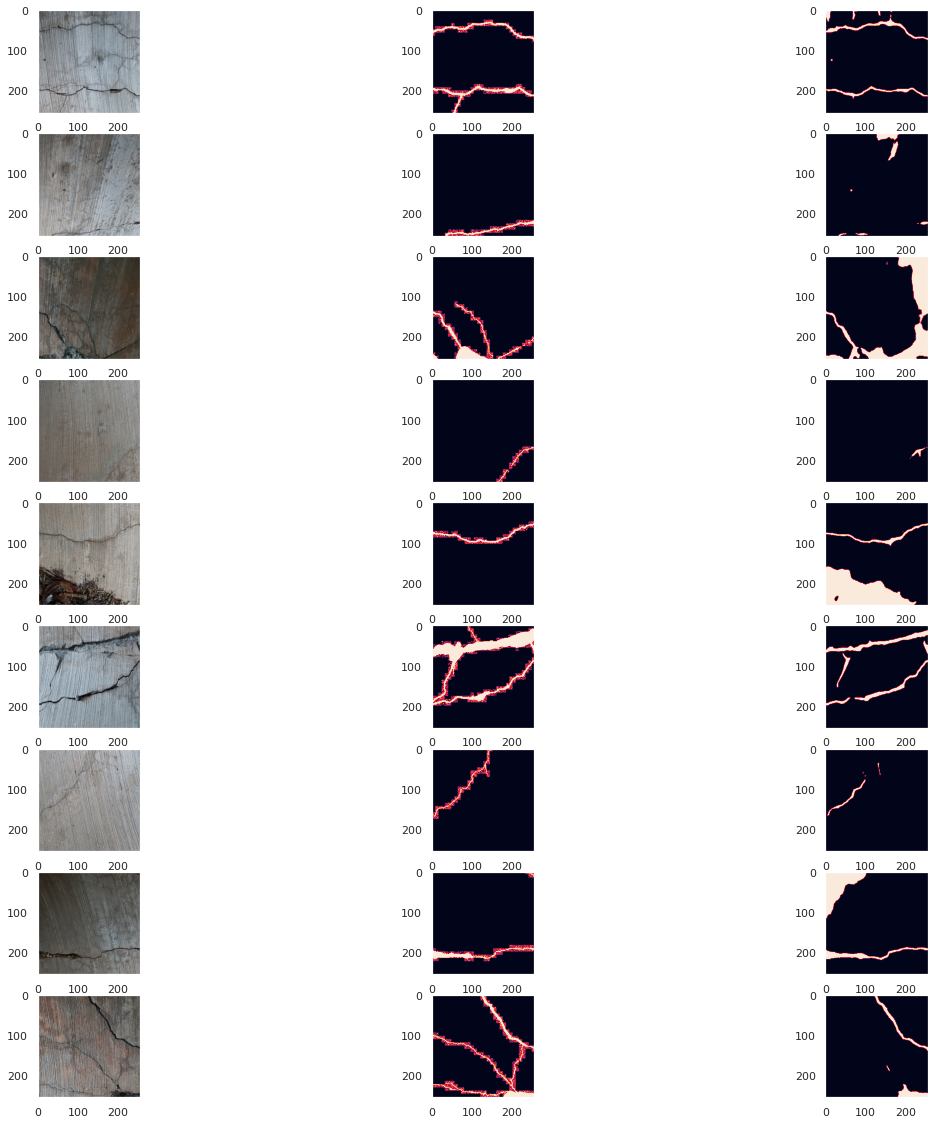

In [80]:
path = r'/home/ubuntu/Desktop/NNDL Project/PIPE NEW 256'
pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

test_lab_path = r'/home/ubuntu/Desktop/NNDL Project/Pipe GT'
pipe_lab_paths = sorted([os.path.join(test_lab_path, fname) for fname in os.listdir(test_lab_path) if fname.endswith(".jpg") and not fname.startswith(".")])


pipe = Generator(pipe_image_paths, pipe_lab_paths, 9, img_dim, augment = False)
for p_test, y_test in pipe:
    break
print(p_test.shape)
print(y_test.shape)
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2],y_test.shape[3])
print(y_test.shape)
y_test = np.expand_dims(y_test[:,:,:,0], axis = -1)
print(y_test.shape)

y_pred = model.predict(p_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

print(yy_true.shape)
print(yy_pred.shape)

print((y_test.flatten().shape))
print((y_pred.flatten().shape))

report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

n=len(p_test)

plt.figure(figsize=(20, 20))

for i in range(n):
    # display image
    plt.grid(False)
    plt.subplot(n,3,3*i+1)
    plt.imshow(p_test[i])
    
    plt.grid(False)
    plt.subplot(n,3,3*i+2)
    plt.imshow(y_test[i])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    plt.subplot(n, 3,  3*(i+1))
    plt.imshow(y_pred[i])

plt.grid(False)
plt.show()